In [2]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd

from numba import jit
from scipy import sparse, special
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

In [3]:
class PoissonMF(BaseEstimator, TransformerMixin):
    ''' Poisson matrix factorization with batch inference '''
    def __init__(self, n_components=100, max_iter=100, tol=0.0001,
                 smoothness=100, random_state=None, verbose=False,
                 **kwargs):
        ''' Poisson matrix factorization

        Arguments
        ---------
        n_components : int
            Number of latent components

        max_iter : int
            Maximal number of iterations to perform

        tol : float
            The threshold on the increase of the objective to stop the
            iteration

        smoothness : int
            Smoothness on the initialization variational parameters

        random_state : int or RandomState
            Pseudo random number generator used for sampling

        verbose : bool
            Whether to show progress during model fitting

        **kwargs: dict
            Model hyperparameters
        '''

        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.smoothness = smoothness
        self.random_state = random_state
        self.verbose = verbose

        if type(self.random_state) is int:
            np.random.seed(self.random_state)
        elif self.random_state is not None:
            np.random.setstate(self.random_state)

        self._parse_args(**kwargs)

    def _parse_args(self, **kwargs):
        self.a = float(kwargs.get('a', 0.1))
        self.b = float(kwargs.get('b', 0.1))
        self.c = float(kwargs.get('c', 0.1))
        self.d = float(kwargs.get('d', 0.1))

    def _init_users(self, n_users):
        # variational parameters for theta
        self.gamma_t = self.smoothness * \
            np.random.gamma(self.smoothness, 1. / self.smoothness,
                            size=(self.n_components, n_users)
                            ).astype(np.float32)
        self.rho_t = self.smoothness * \
            np.random.gamma(self.smoothness, 1. / self.smoothness,
                            size=(self.n_components, n_users)
                            ).astype(np.float32)
        self.Et, self.Elogt = _compute_expectations(self.gamma_t, self.rho_t)

    def _init_items(self, n_items):
        # variational parameters for beta
        self.gamma_b = self.smoothness * \
            np.random.gamma(self.smoothness, 1. / self.smoothness,
                            size=(n_items, self.n_components)
                            ).astype(np.float32)
        self.rho_b = self.smoothness * \
            np.random.gamma(self.smoothness, 1. / self.smoothness,
                            size=(n_items, self.n_components)
                            ).astype(np.float32)
        self.Eb, self.Elogb = _compute_expectations(self.gamma_b, self.rho_b)

    def fit(self, X, rows, cols, vad=None):
        '''Fit the model to the data in X.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_feats)
            Training data.

        Returns
        -------
        self: object
            Returns the instance itself.
        '''
        n_items, n_users = X.shape
        self._init_items(n_items)
        self._init_users(n_users)
        self._update(X, rows, cols, vad=vad)
        return self

    def transform(self, X, rows, cols, attr=None):
        '''Encode the data as a linear combination of the latent components.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_feats)

        attr: string
            The name of attribute, default 'Eb'. Can be changed to Elogb to
            obtain E_q[log beta] as transformed data.

        Returns
        -------
        X_new : array-like, shape(n_samples, n_filters)
            Transformed data, as specified by attr.
        '''

        if not hasattr(self, 'Et'):
            raise ValueError('There are no pre-trained components.')
        n_items, n_users = X.shape
        if n_users != self.Et.shape[1]:
            raise ValueError('The dimension of the transformed data '
                             'does not match with the existing components.')
        if attr is None:
            attr = 'Eb'
        self._init_items(n_items)
        self._update(X, rows, cols, update_theta=False)
        return getattr(self, attr)

    def _update(self, X, rows, cols, update_theta=True, vad=None):
        # alternating between update latent components and weights
        old_pll = -np.inf
        for i in range(self.max_iter):
            if update_theta:
                self._update_users(X, rows, cols)
            self._update_items(X, rows, cols)
            if vad is not None:
                pred_ll = self.pred_loglikeli(**vad)
                improvement = (pred_ll - old_pll) / abs(old_pll)
                if self.verbose:
                    print('ITERATION: %d\tPred_ll: %.2f\tOld Pred_ll: %.2f\t'
                        'Improvement: %.5f' % (i, pred_ll, old_pll, improvement))
                    sys.stdout.flush()
                if improvement < self.tol:
                    break
                old_pll = pred_ll
        pass

    def _update_users(self, X, rows, cols):
        ratioT = sparse.csr_matrix((X.data / self._xexplog(rows, cols),
                                    (rows, cols)),
                                   dtype=np.float32, shape=X.shape).transpose()
        self.gamma_t = self.a + np.exp(self.Elogt) * \
            ratioT.dot(np.exp(self.Elogb)).T
        self.rho_t = self.b + np.sum(self.Eb, axis=0, keepdims=True).T
        self.Et, self.Elogt = _compute_expectations(self.gamma_t, self.rho_t)

    def _update_items(self, X, rows, cols):
        ratio = sparse.csr_matrix((X.data / self._xexplog(rows, cols),
                                   (rows, cols)),
                                  dtype=np.float32, shape=X.shape)
        self.gamma_b = self.c + np.exp(self.Elogb) * \
            ratio.dot(np.exp(self.Elogt.T))
        self.rho_b = self.d + np.sum(self.Et, axis=1)
        self.Eb, self.Elogb = _compute_expectations(self.gamma_b, self.rho_b)

    def _xexplog(self, rows, cols):
        '''
        sum_k exp(E[log theta_{ik} * beta_{kd}])
        '''
        data = _inner(np.exp(self.Elogb), np.exp(self.Elogt), rows, cols)
        return data

    def pred_loglikeli(self, X_new, rows_new, cols_new):
        X_pred = _inner(self.Eb, self.Et, rows_new, cols_new)
        pred_ll = np.mean(X_new * np.log(X_pred) - X_pred)
        return pred_ll

In [4]:
def _inner(beta, theta, rows, cols):
    n_ratings = rows.size
    n_components, n_users = theta.shape
    beta = beta.reshape((-1, n_components))    
    data = np.empty(n_ratings, dtype=np.float32)
    for i in range(n_ratings):
        data[i] = 0
        for j in range(n_components):
            beta_ij = beta[rows[i], j]
            theta_ij = theta[j, cols[i]]
#             data[i] += beta[rows[i] * n_components + j] * theta[j * n_users + cols[i]]
            data[i] += beta_ij*theta_ij
    return data

def _compute_expectations(alpha, beta):
    '''
    Given x ~ Gam(alpha, beta), compute E[x] and E[log x]
    '''
    return (alpha / beta, special.psi(alpha) - np.log(beta))

In [5]:
train_cols = ['user_id', 'item_id', 'rating', 'timestamp']
trainDf = pd.read_csv('C:/Users/kenny/Desktop/Spring 2021/CSE547_Project/data/MovieLens.training', sep='\t', lineterminator='\n')
trainDf.columns = train_cols

In [6]:
trainDf=trainDf.drop(["timestamp"], axis=1)

In [7]:
n_users = 943
n_movies = 1682
trainDf["user_id"] -= 1
trainDf["item_id"] -= 1
def load_data(df, colnames=["uid", "sid", "rating"], shape=(n_users, n_movies)):
    user, item, rating = colnames[0], colnames[1], colnames[2]
    rows, cols, vals = np.array(df[user]), np.array(df[item]), np.array(df[rating])
    data = sparse.csr_matrix((vals, (rows, cols)), dtype=np.float32, shape=shape)
    return data
def exp_to_imp(data, cutoff=1e-10):
    data_imp = data.copy()
    data_imp.data[data_imp.data < cutoff] = 0
    data_imp.data[data_imp.data >= cutoff] = 1
    data_imp.data = data_imp.data.astype('int32')
    data_imp.eliminate_zeros()
    return data_imp
data = load_data(trainDf, colnames=['user_id', 'item_id', 'rating'], shape=(n_users, n_movies))
print(data.shape)

(943, 1682)


In [8]:
data_imp = exp_to_imp(data, 0.5)
data_coo = data_imp.tocoo()
row_tr, col_tr = data_coo.row, data_coo.col
pf = PoissonMF(n_components=10, max_iter=100)
pf.fit(data, row_tr, col_tr)
pi, lamb = pf.Eb.copy(), pf.Et.T

print(pi.shape)
print(lamb.shape)

(943, 10)
(1682, 10)


In [9]:
a_hat=np.matmul(pi,lamb.T)

In [10]:
a_hat.shape

(943, 1682)

In [11]:
import numpy as np
from numpy import linalg as LA 
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

In [12]:
trainDf

,user_id,item_id,rating
0,0,1,3
1,0,2,4
2,0,3,3
3,0,4,3
4,0,6,4
5,0,7,1
6,0,8,5
7,0,10,2
8,0,12,5
9,0,14,5


In [13]:
R=np.zeros((943,1682))
for i in range(len(trainDf)):
    R[trainDf['user_id'][i]][trainDf['item_id'][i]]=trainDf['rating'][i]
I=(R>0)*1.0

In [14]:
def calculate_loss(U,V,R,I,ahat,gamma,lamb):
    s=0
    k=0
    m=0
    for i in range(len(U)):
        for j in range(len(V)):
            s=s+I[i][j]*(R[i][j]-np.dot(U[i],V[j])-ahat[i][j]*gamma[i])**2
    for i in range(len(U)):
        k=k+LA.norm(U[i])**2
    for i in range(len(V)):
        m=m+LA.norm(V[i])**2
    return s+lamb*(m+k)

In [119]:
loss=[]
num_latent_factors=10
V=csr_matrix((1682, num_latent_factors))
lamb=0.001
U=csr_matrix(np.zeros((943,num_latent_factors))+0.5)
gamma=np.zeros(943)+0.3

In [120]:
loss.append(calculate_loss(U.toarray(),V.toarray(),R,I,a_hat,gamma,lamb))

In [141]:
import warnings
warnings.filterwarnings("ignore")
for j in range (10):
    #UU=np.matmul(U.toarray().T,U.toarray())
    for i in range(1682):
        U_i = U.toarray()[R[:, i] > 0,:]
        A=csr_matrix(np.matmul(U_i.T,U_i)+lamb*np.identity(num_latent_factors))
        B=csr_matrix(np.matmul(U_i.T,R[ R[:,i] > 0,i])-np.matmul(U_i.T,np.multiply(gamma[ R[:,i] > 0],a_hat[ R[:,i] > 0,i])))
        V[i,:] = spsolve(A, csr_matrix.transpose(B))
    #V = V[:, R[i, :] > 0]
    #VV=np.matmul(V.toarray().T,V.toarray())
    for u in range(943):
        V_u = V.toarray()[R[u, :] > 0,:]
        A=csr_matrix(np.matmul(V_u.T,V_u)+lamb*np.identity(num_latent_factors))
        B=csr_matrix(np.matmul(V_u.T,R[u, R[u, :] > 0])-gamma[u]*np.matmul(V_u.T,a_hat[u, R[u, :] > 0]))
        #B=csr_matrix(np.matmul(np.matmul(Y.toarray().T,(L_C_u_1[u]+np.identity(3000))),L_P_2[u]))
        U[u,:] = spsolve(A, csr_matrix.transpose(B))
        gamma[u]=(np.dot(R[u, R[u, :] > 0],a_hat[u, R[u, :] > 0])-np.dot(np.matmul(U.toarray()[u],V_u.T),a_hat[u, R[u, :] > 0]))/np.dot(a_hat[u, R[u, :] > 0],a_hat[u, R[u, :] > 0])
    loss.append(calculate_loss(U.toarray(),V.toarray(),R,I,a_hat,gamma,lamb))

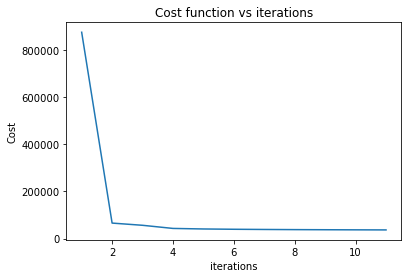

In [142]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,len(loss)+1,1),loss)
plt.title('Cost function vs iterations')
plt.xlabel('iterations')
plt.ylabel('Cost')
plt.show()

In [145]:
loss

[875624.530067225,
 65905.70677354326,
 56526.02796438471,
 43227.602260326195,
 40911.68344354152,
 39662.11113018942,
 38821.67533249252,
 38191.02295806778,
 37686.137807590334,
 37266.82283640529,
 36913.743939886284]

In [143]:
R_hat=np.zeros(a_hat.shape)
for i in range(len(gamma)):
    R_hat[i,:]=gamma[i]*a_hat[i]
R_hat=np.multiply(R_hat,I)+np.matmul(U.toarray()[0],V.toarray().T)

In [144]:
R_hat

array([[ 3.14639636,  3.0692047 ,  4.02236219, ...,  0.52961875,
        -0.57531311,  0.10481288],
       [ 3.13106562,  2.91624077,  3.90788506, ...,  0.52961875,
        -0.57531311,  0.10481288],
       [ 3.14639636,  2.91624077,  3.90788506, ...,  0.52961875,
        -0.57531311,  0.10481288],
       ...,
       [ 4.21170457,  2.91624077,  3.90788506, ...,  0.52961875,
        -0.57531311,  0.10481288],
       [ 3.14639636,  2.91624077,  3.90788506, ...,  0.52961875,
        -0.57531311,  0.10481288],
       [ 3.14639636,  2.99606641,  3.90788506, ...,  0.52961875,
        -0.57531311,  0.10481288]])

In [101]:
R_hat.shape

(943, 1682)

In [86]:
trainDf[90:]

,user_id,item_id,rating
90,0,171,5
91,0,172,5
92,0,175,5
93,0,177,5
94,0,178,3
95,0,180,5
96,0,181,4
97,0,186,4
98,0,190,5
99,0,191,4
